In [37]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [38]:
PROJECT_PATH = Path.cwd().parent
DATA_PATH = PROJECT_PATH / "Dataset" / "cleaned_dataset.csv"

In [ ]:
df = pd.read_csv(DATA_PATH)

In [40]:
# Traget Encoding
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [41]:
print("Target distribution:")
print(df['Churn'].value_counts(normalize=True))

Target distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [42]:
# Drop unnecessary columns
df = df.drop(columns=['TotalCharges'])

In [43]:
# Tenure group
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 48, 72],
    labels=['0-1yr', '1-2yr', '2-4yr', '4+yr']
)

In [44]:
# High Monthly Charges flag
df['HighCharges'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)


In [45]:
# Auto Payment flag
df['AutoPayment'] = df['PaymentMethod'].apply(
    lambda x: 1 if 'automatic' in x else 0
)

In [46]:
# High Risk Segment flag
df['HighRiskSegment'] = (
    (df['Contract'] == 'Month-to-month') &
    (df['InternetService'] == 'Fiber optic') &
    (df['tenure'] < 12)
).astype(int)

In [47]:
X = df.drop('Churn', axis=1)
y = df['Churn']

cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [49]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, clf in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df)


Model Comparison:
                 Model  Accuracy    Recall        F1   ROC_AUC
0  Logistic Regression  0.733854  0.783422  0.609781  0.840492
1        Random Forest  0.782825  0.475936  0.537764  0.813507
2    Gradient Boosting  0.801987  0.508021  0.576631  0.843658


In [50]:
pipelines = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ]),
    
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}

param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    
    "Random Forest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 5, 10]
    },
    
    "Gradient Boosting": {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    }
}


In [ ]:
tuned_results = []
best_models = {}

for name in pipelines.keys():
    
    print(f"\nTuning {name}...")
    
    grid = GridSearchCV(
        pipelines[name],
        param_grids[name],
        cv=5,
        scoring='recall',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    
    y_prob = grid.best_estimator_.predict_proba(X_test)[:, 1]
    y_pred = grid.best_estimator_.predict(X_test)

    tuned_results.append({
        "Model": name,
        "Best_Params": grid.best_params_,
        "Recall": recall_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    })

tuned_results_df = pd.DataFrame(tuned_results)
print("\nTuned Model Comparison:")
print(tuned_results_df)



Tuning Logistic Regression...

Tuning Random Forest...

Tuning Gradient Boosting...

Tuned Model Comparison:
                 Model                                        Best_Params  \
0  Logistic Regression  {'classifier__C': 1, 'classifier__penalty': 'l2'}   
1        Random Forest  {'classifier__max_depth': 5, 'classifier__n_es...   
2    Gradient Boosting  {'classifier__learning_rate': 0.1, 'classifier...   

     Recall   ROC_AUC  
0  0.783422  0.840492  
1  0.791444  0.840454  
2  0.516043  0.834125  


In [52]:
# Get tuned models
log_model = best_models["Logistic Regression"]
rf_model = best_models["Random Forest"]

# Predict probabilities
log_probs = log_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]


In [53]:
thresholds = [0.5, 0.4, 0.35, 0.3, 0.25]

comparison_results = []

for t in thresholds:
    
    # Logistic predictions
    log_pred = (log_probs >= t).astype(int)
    
    # Random Forest predictions
    rf_pred = (rf_probs >= t).astype(int)
    
    comparison_results.append({
        "Threshold": t,
        
        "Log_Recall": recall_score(y_test, log_pred),
        "Log_Precision": precision_score(y_test, log_pred),
        "Log_F1": f1_score(y_test, log_pred),
        
        "RF_Recall": recall_score(y_test, rf_pred),
        "RF_Precision": precision_score(y_test, rf_pred),
        "RF_F1": f1_score(y_test, rf_pred)
    })

threshold_df = pd.DataFrame(comparison_results)

# Find best recall across both models
threshold_df["Best_Model"] = threshold_df.apply(
    lambda row: "Logistic Regression"
    if row["Log_Recall"] > row["RF_Recall"]
    else "Random Forest",
    axis=1
)

print("\nThreshold Comparison with Winner:")
print(threshold_df)


Threshold Comparison with Winner:
   Threshold  Log_Recall  Log_Precision    Log_F1  RF_Recall  RF_Precision  \
0       0.50    0.783422       0.499148  0.609781   0.791444      0.507719   
1       0.40    0.871658       0.475219  0.615094   0.874332      0.456067   
2       0.35    0.906417       0.449007  0.600531   0.911765      0.432741   
3       0.30    0.927807       0.426814  0.584667   0.957219      0.410550   
4       0.25    0.941176       0.409779  0.570965   0.962567      0.384615   

      RF_F1     Best_Model  
0  0.618600  Random Forest  
1  0.599450  Random Forest  
2  0.586919  Random Forest  
3  0.574639  Random Forest  
4  0.549618  Random Forest  


In [54]:
# Find overall best recall
best_row = threshold_df.loc[
    threshold_df[["Log_Recall", "RF_Recall"]].max(axis=1).idxmax()
]

print("\nBest Configuration Found:")
print(best_row)



Best Configuration Found:
Threshold                 0.25
Log_Recall            0.941176
Log_Precision         0.409779
Log_F1                0.570965
RF_Recall             0.962567
RF_Precision          0.384615
RF_F1                 0.549618
Best_Model       Random Forest
Name: 4, dtype: object


In [55]:
best_model_name = tuned_results_df.sort_values(
    by="Recall", ascending=False
).iloc[0]["Model"]

best_model = best_models[best_model_name]

print(f"\nSelected Final Model: {best_model_name}")



Selected Final Model: Random Forest


In [56]:
y_prob = best_model.predict_proba(X_test)[:, 1]

# Threshold tuning
best_threshold_row = threshold_df.loc[
    threshold_df["RF_Recall"].idxmax()
]

optimal_threshold = best_threshold_row["Threshold"]

print("Optimal Threshold:", optimal_threshold)

y_pred_final = (y_prob >= optimal_threshold).astype(int)

print("\nFinal Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Recall:", recall_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final))
print("F1 Score:", f1_score(y_test, y_pred_final))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

Optimal Threshold: 0.25

Final Model Performance:
Accuracy: 0.5812633073101491
Recall: 0.9625668449197861
Precision: 0.38461538461538464
F1 Score: 0.549618320610687
ROC AUC: 0.8404544162856183

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.44      0.61      1035
           1       0.38      0.96      0.55       374

    accuracy                           0.58      1409
   macro avg       0.68      0.70      0.58      1409
weighted avg       0.81      0.58      0.59      1409



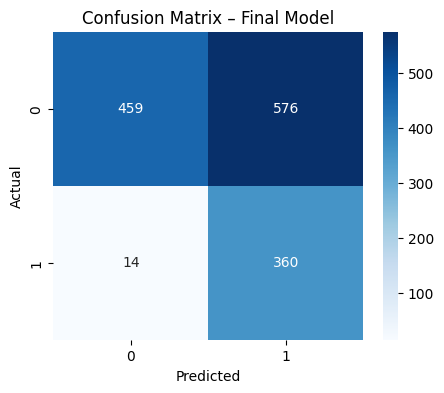

In [57]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_final), 
            annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Final Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [58]:
rf_model = best_model.named_steps['classifier']

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

importances = rf_model.feature_importances_

feat_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_importance_df.head(15))


                                 Feature  Importance
38          cat__Contract_Month-to-month    0.161883
1                            num__tenure    0.103662
20                cat__OnlineSecurity_No    0.098319
40                cat__Contract_Two year    0.094546
29                   cat__TechSupport_No    0.064163
45   cat__PaymentMethod_Electronic check    0.060667
5                   num__HighRiskSegment    0.055365
47               cat__tenure_group_0-1yr    0.045885
18      cat__InternetService_Fiber optic    0.044007
2                    num__MonthlyCharges    0.028633
50                cat__tenure_group_4+yr    0.027321
39                cat__Contract_One year    0.025100
23                  cat__OnlineBackup_No    0.015914
33  cat__StreamingTV_No internet service    0.013623
19               cat__InternetService_No    0.013494


In [60]:
MODEL_PATH = PROJECT_PATH / "Models"
MODEL_PATH.mkdir(exist_ok=True)

# Save best model
joblib.dump(best_model, MODEL_PATH / "best_churn_model.pkl")

# Save feature columns
joblib.dump(X.columns.tolist(), MODEL_PATH / "model_features.pkl")

print("Model and features saved successfully.")

Model and features saved successfully.
